In [47]:
import pandas as pd
import numpy as np
import ast
from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings

In [48]:
ia_A_path = "full/ia_A.csv"
df_A = pd.read_csv(ia_A_path)

In [49]:
article_col='article_id'
difficulty_col='difficulty_level'
batch_col='article_batch'
paragraph_col='paragraph_id'

df_A['text_id'] = (
    df_A[article_col].astype(str) + '_' +
    df_A[difficulty_col].astype(str) + '_' +
    df_A[batch_col].astype(str) + '_' +
    df_A[paragraph_col].astype(str)
)

In [50]:
df_A_filtered = df_A[(df_A['repeated_reading_trial'] == False) & ((df_A['practice_trial'] == False))]

df_A_hunters = df_A_filtered[df_A_filtered['question_preview'] == True]
df_A_gatherers = df_A_filtered[df_A_filtered['question_preview'] == False]

In [51]:
def create_area_label(df):
    for col in ['question', 'answer_1', 'answer_2', 'answer_3', 'answer_4']:
        df[col] = df[col].fillna('').astype(str)

    df['question_tokens'] = df['question'].str.split()
    df['a_tokens'] = df['answer_1'].str.split()
    df['b_tokens'] = df['answer_2'].str.split()
    df['c_tokens'] = df['answer_3'].str.split()
    df['d_tokens'] = df['answer_4'].str.split()

    df['question_len'] = df['question_tokens'].apply(len)
    df['a_len'] = df['a_tokens'].apply(len)
    df['b_len'] = df['b_tokens'].apply(len)
    df['c_len'] = df['c_tokens'].apply(len)
    df['d_len'] = df['d_tokens'].apply(len)

    def assign_area(group):
        q_len = group['question_len'].iloc[0]
        a_len = group['a_len'].iloc[0]
        b_len = group['b_len'].iloc[0]
        c_len = group['c_len'].iloc[0]
        d_len = group['d_len'].iloc[0]

        q_end = q_len - 1
        a_end = q_len + a_len - 1
        b_end = q_len + a_len + b_len - 1
        c_end = q_len + a_len + b_len + c_len - 1
        d_end = q_len + a_len + b_len + c_len + d_len

        index_id = group['IA_ID'] - 1

        conditions = [
            (index_id <= q_end),
            (index_id > q_end) & (index_id <= a_end),
            (index_id > a_end) & (index_id <= b_end),
            (index_id > b_end) & (index_id <= c_end),
            (index_id > c_end) & (index_id <= d_end)
        ]

        choices = ['question', 'answer_A', 'answer_B', 'answer_C', 'answer_D']
        group['area_label'] = np.select(conditions, choices, default='unknown')
        return group

    df_area_split = df.set_index(['TRIAL_INDEX', 'participant_id']).groupby(['TRIAL_INDEX', 'participant_id'], group_keys=False).apply(assign_area)
    return df_area_split

In [52]:
def create_correct_answer(df):
    df = df.copy()
    df['is_correct'] = (df['selected_answer_position'] == df['correct_answer_position']).astype(int)
    return df

In [53]:
def create_area_screen_loc(df):
    def get_screen_loc(row):
        if row['area_label'] == 'question':
            return -1
        elif row['area_label'].startswith('answer_'):
            answers_order = ast.literal_eval(row['answers_order'])
            answer_letter = row['area_label'][-1]
            return answers_order.index(answer_letter)
        return None

    df['area_screen_loc'] = df.apply(get_screen_loc, axis=1)
    return df

In [54]:
def create_selected_answer_label(df):
    df = df.copy()
    df['answers_order'] = df['answers_order'].apply(ast.literal_eval)
    df['selected_answer_label'] = df.apply(lambda row: row['answers_order'][row['selected_answer_position']], axis=1)
    return df

In [55]:
def created_selected_area_bool(df):
    area_mapping = {
    'A': 'answer_A',
    'B': 'answer_B',
    'C': 'answer_C',
    'D': 'answer_D'
    }

    df['selected_area'] = df['selected_answer_label'].map(area_mapping)
    df['is_selected_area'] = df['area_label'] == df['selected_area']
    return df

In [56]:
def process_dataframe(df, functions):
    for func in functions:
        print(func)
        df = func(df)
    return df.reset_index()

processing_functions = [
    create_correct_answer,
    create_area_label,
    create_area_screen_loc,
    create_selected_answer_label,
    created_selected_area_bool,
]

df_base_features_h = process_dataframe(df_A_hunters, processing_functions)
df_base_features_g = process_dataframe(df_A_gatherers, processing_functions)

<function create_correct_answer at 0x000002D44F37C310>
<function create_area_label at 0x000002D44F37C670>
<function create_area_screen_loc at 0x000002D44F37D090>
<function create_selected_answer_label at 0x000002D444D8BD90>
<function created_selected_area_bool at 0x000002D44F37C3A0>
<function create_correct_answer at 0x000002D44F37C310>
<function create_area_label at 0x000002D44F37C670>
<function create_area_screen_loc at 0x000002D44F37D090>
<function create_selected_answer_label at 0x000002D444D8BD90>
<function created_selected_area_bool at 0x000002D44F37C3A0>


In [57]:
def create_fixation_sequence_tags(df):
    ia_id_to_label = dict(zip(df['IA_ID'], df['area_label']))
    ia_id_to_location = dict(zip(df['IA_ID'], df['area_screen_loc']))

    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)
        label_sequence = [ia_id_to_label.get(ia_id, 'out_of_bounds') for ia_id in sequence]
        location_sequence = [ia_id_to_location.get(ia_id, 'out_of_bounds') for ia_id in sequence]
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'fix_by_label': label_sequence,
            'fix_by_loc': location_sequence
        })

    return pd.DataFrame(result)

In [82]:
def create_fixation_sequence_tags_no_unknowns(df):
    ia_id_to_label = dict(zip(df['IA_ID'], df['area_label']))
    ia_id_to_location = dict(zip(df['IA_ID'], df['area_screen_loc']))

    result = []
    for (trial_index, participant_id), group in df.groupby(['TRIAL_INDEX', 'participant_id']):
        sequence_str = group['INTEREST_AREA_FIXATION_SEQUENCE'].iloc[0]
        sequence = eval(sequence_str)
        label_sequence = []
        location_sequence = []
        for ia_id in sequence:
            if ia_id not in ia_id_to_label or ia_id not in ia_id_to_location:
                continue
            label_sequence.append(ia_id_to_label[ia_id])
            location_sequence.append(ia_id_to_location[ia_id])
        result.append({
            'TRIAL_INDEX': trial_index,
            'participant_id': participant_id,
            'fix_by_label_clean': label_sequence,
            'fix_by_loc_clean': location_sequence
        })

    return pd.DataFrame(result)

In [83]:
def generate_new_row_features(functions, df, default_join_columns=['TRIAL_INDEX', 'participant_id', 'area_label']):
    result_df = df.copy()

    for func_tuple in functions:
        func, func_kwargs = func_tuple
        print(func)

        join_columns = func_kwargs.get('join_columns', default_join_columns)

        new_features_df = func(df)
        result_df = result_df.merge(new_features_df, on=join_columns, how='left')

    return result_df

In [84]:
per_row_feature_generators = [
    (create_fixation_sequence_tags, {'join_columns': ['TRIAL_INDEX', 'participant_id']}),
    (create_fixation_sequence_tags_no_unknowns, {'join_columns': ['TRIAL_INDEX', 'participant_id']})
]

df_with_features_h = generate_new_row_features(per_row_feature_generators, df_base_features_h)
df_with_features_g = generate_new_row_features(per_row_feature_generators, df_base_features_g)

<function create_fixation_sequence_tags at 0x000002D451B508B0>
<function create_fixation_sequence_tags_no_unknowns at 0x000002D2813D30A0>
<function create_fixation_sequence_tags at 0x000002D451B508B0>
<function create_fixation_sequence_tags_no_unknowns at 0x000002D2813D30A0>


In [85]:
categories_label = {
    "question": "#74a9cf",
    "answer_A": "#238b45",
    "answer_B": "#74c476",
    "answer_C": "#bae4b3",
    "answer_D": "#edf8e9",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "white"
}

categories_loc = {
    -1: "#74a9cf",
    0: "#ffffb2",
    1: "#fecc5c",
    2: "#fd8d3c",
    3: "#e31a1c",

    "A": "green",
    "B": "gold",
    "C": "darkorange",
    "D": "red",

    "out_of_bounds": "white"
}

legend_mapping_label = {
    "question": "Question",
    "answer_A": "Answer A",
    "answer_B": "Answer B",
    "answer_C": "Answer C",
    "answer_D": "Answer D",
    "out_of_bounds": "Unclear",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}

legend_mapping_loc = {
    "out_of_bounds": "Unclear",
    -1: "Question",
    0: "First A on screen",
    1: "Second A on screen",
    2: "Third A on screen",
    3: "Fourth A on screen",

    "A": None,
    "B": None,
    "C": None,
    "D": None,
}

In [86]:
def visualize_stacked_rows_with_two_labels(data_rows, categories, selected_answer_labels, additional_labels, num_rows=100, start_index=0, legend_mapping=None):
    selected_rows = data_rows[start_index:start_index + num_rows]
    selected_labels = selected_answer_labels[start_index:start_index + num_rows]
    additional_labels = additional_labels[start_index:start_index + num_rows]


    max_length = max(len(row) for row in selected_rows) + 2  # +2 to account for the labels

    color_data = []
    for row in selected_rows:
        color_row = [categories.get(value, "gray") for value in row] + ["white"] * (max_length - len(row))
        color_data.append(color_row)

    plt.figure(figsize=(15, num_rows * 0.3))
    for i, (color_row, label, additional_label) in enumerate(zip(color_data, selected_labels, additional_labels)):
        plt.bar(range(max_length), [1] * max_length, color=color_row, width=1.0, edgecolor='none', bottom=i)
        plt.text(-3.5, i + 0.5, str(additional_label), va='center', ha='right', fontsize=10, color=categories.get(additional_label, "black"))
        plt.text(-1.5, i + 0.5, str(label), va='center', ha='right', fontsize=10, color=categories.get(label, "black"))

    plt.axis('off')

    if legend_mapping:
        legend_handles = [
            mpatches.Patch(color=categories.get(original_label, "gray"), label=new_label)
            for original_label, new_label in legend_mapping.items()
            if new_label is not None
        ]
    else:
        legend_handles = [
            mpatches.Patch(color=color, label=str(label)) for label, color in categories.items()
        ]

    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

    plt.tight_layout()
    plt.show()

In [87]:
df_with_features_h['fix_by_label_clean'] = df_with_features_h['fix_by_label_clean'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_label_clean'] = df_with_features_g['fix_by_label_clean'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_h['fix_by_loc_clean'] = df_with_features_h['fix_by_loc_clean'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_with_features_g['fix_by_loc_clean'] = df_with_features_g['fix_by_loc_clean'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

data_rows_h = df_with_features_h[['TRIAL_INDEX', 'participant_id', 'text_id', 'fix_by_label_clean', 'fix_by_loc_clean','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()
data_rows_g = df_with_features_g[['TRIAL_INDEX', 'participant_id', 'text_id', 'fix_by_label_clean', 'fix_by_loc_clean','selected_answer_label', 'correct_answer_position']].drop_duplicates().reset_index()

In [90]:
import random

def visualize_by_id(data, by_person_or_text, fix_by, identifier=None):
    if by_person_or_text not in ['person', 'text']:
        raise ValueError("The 'by_person_or_text' parameter must be either 'person' or 'text'.")

    if fix_by not in ['label', 'loc']:
        raise ValueError("The 'fix_by' parameter must be either 'label' or 'loc'.")

    if fix_by == 'label':
        categories = categories_label
        legend_mapping = legend_mapping_label
        data_column = 'fix_by_label_clean'
    else:  # fix_by == 'loc'
        categories = categories_loc
        legend_mapping = legend_mapping_loc
        data_column = 'fix_by_loc_clean'

    filter_column = 'participant_id' if by_person_or_text == 'person' else 'text_id'

    if identifier is None:
        available_ids = data[filter_column].dropna().unique()
        if len(available_ids) == 0:
            raise ValueError(f"No valid entries found in column '{filter_column}'.")
        identifier = random.choice(available_ids)
        print(f"Randomly selected {filter_column}: {identifier}")

    subset = data[data[filter_column] == identifier]
    if subset.empty:
        print(f"No data found for {filter_column} = {identifier}.")
        return

    try:
        fix_data_rows = subset[data_column].tolist()
    except KeyError:
        raise KeyError(f"Column '{data_column}' not found in the data.")

    selected_answer_labels = subset['selected_answer_label'].tolist()
    additional_labels = subset['correct_answer_position'].tolist()

    visualize_stacked_rows_with_two_labels(
        fix_data_rows, categories, selected_answer_labels, additional_labels,
        num_rows=len(fix_data_rows), legend_mapping=legend_mapping
    )



Randomly selected text_id: 8_Ele_3_3


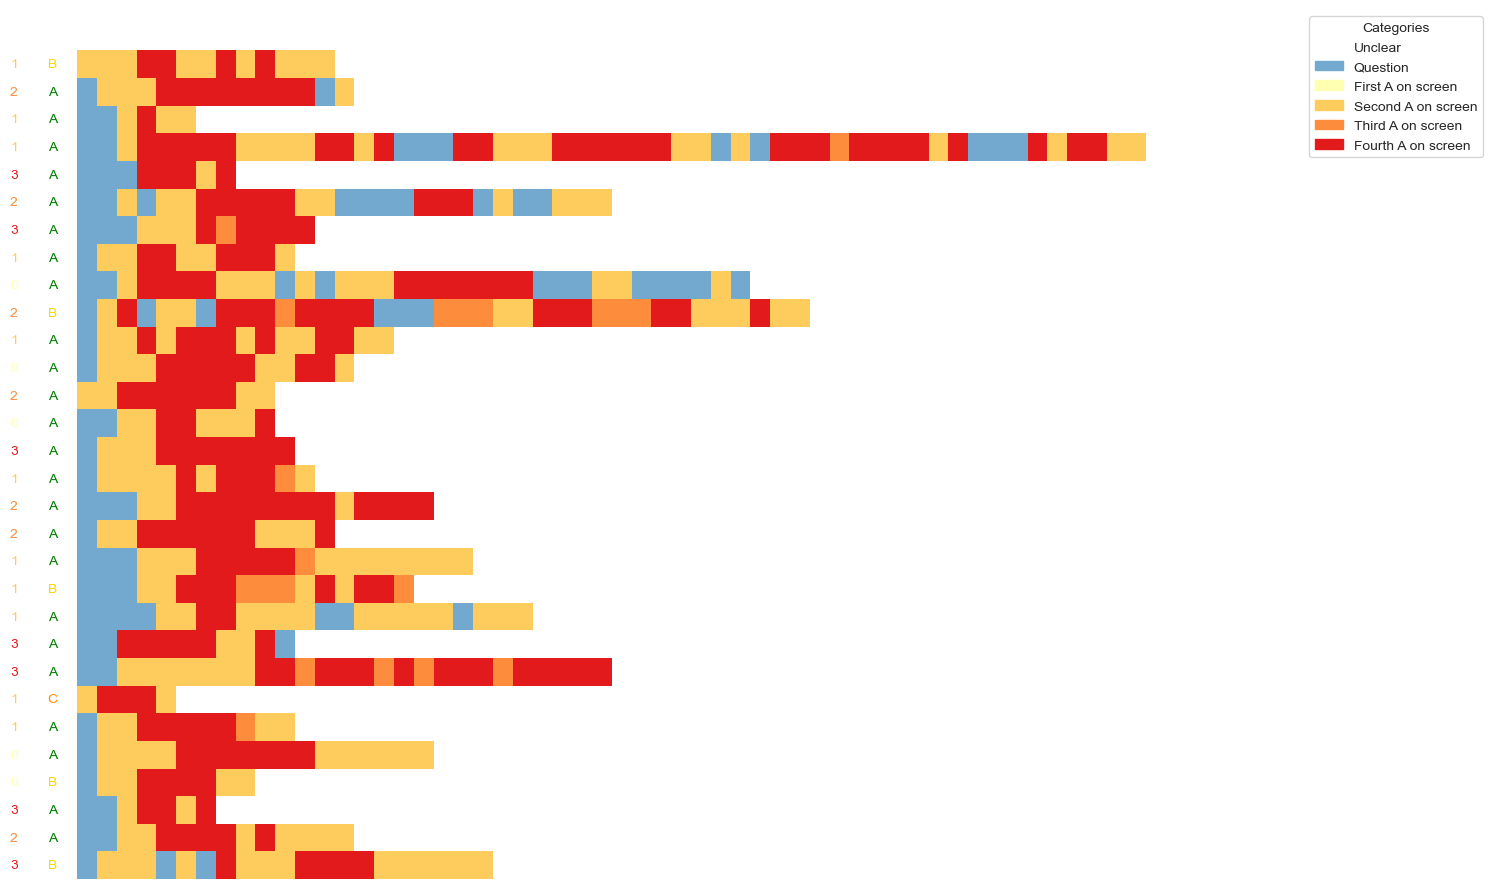

In [104]:
visualize_by_id(data_rows_h, by_person_or_text='text', fix_by='loc', identifier=None)